In [18]:
import numpy as np
import matplotlib.pyplot as plt

import oqupy
import oqupy.operators as op

from scipy.optimize import minimize, Bounds
from typing import List,Tuple

# --- Parameters --------------------------------------------------------------

# -- time steps --
dt = 0.05 # 0.2
num_steps = 100 # 20

# -- bath --
alpha =  0.126 #0.08
omega_cutoff = 3.04 #4
temperature =  5 * 0.1309 #1.6
pt_dkmax =60 # 40
pt_epsrel = 10**(-7) #1.0e-5

# -- initial and target state --
initial_state = op.spin_dm('x-')
target_state = op.spin_dm('x+')

# -- initial parameter guess --
x0= np.zeros(num_steps)
z0 = np.ones(num_steps) * (np.pi) / (dt*num_steps)
'''
for i in range(len(z0)):
    if i % 2 == 0:
        z0[i]=0
'''

#parameter_list=[i[0] for i in zip(x0,z0)]

parameter_list=[item for pair in zip(x0, z0) for item in pair] # this makes a list without the inner tuples

#parameter_list = list(zip(x0,z0))
#num_params = len(parameter_list[0])

In [19]:
halfparalist=[item for item in zip(x0,z0) for i in range(2)]

In [20]:
# --- Compute process tensors -------------------------------------------------
correlations = oqupy.PowerLawSD(alpha=alpha,
                                zeta=3,
                                cutoff=omega_cutoff,
                                cutoff_type='gaussian',
                                temperature=temperature)
bath = oqupy.Bath(oqupy.operators.sigma("z")/2, correlations)


pt_tempo_parameters = oqupy.TempoParameters(
    dt=dt,
    epsrel=pt_epsrel,
    dkmax=pt_dkmax)
process_tensor = oqupy.pt_tempo_compute(
    bath=bath,
    start_time=0.0,
    end_time=num_steps * dt,
    parameters=pt_tempo_parameters,
    progress_type='bar')

--> PT-TEMPO computation:
100.0%  100 of  100 [########################################] 00:00:10
Elapsed time: 10.4s


In [21]:
def hamiltonian(hx,hz):

    hx_sx = 0.5 * oqupy.operators.sigma('x') * hx
    hz_sz = 0.5 * oqupy.operators.sigma('z') * hz

    return hz_sz + hx_sx

parameterized_system=oqupy.ParameterizedSystem(hamiltonian)



In [22]:
import tensornetwork as tn

In [23]:
fsadj=oqupy.compute_gradient_and_dynamics(
        system=parameterized_system,
        initial_state=initial_state,
        target_state=target_state,
        process_tensor=process_tensor,
        parameters=halfparalist)[0][1]
firsthalfprop,secondhalfprop=parameterized_system.get_propagators(dt,halfparalist)(1)
fpt=tn.Node(firsthalfprop.T)
spt=tn.Node(secondhalfprop.T)
fsadj[0] ^ fpt[0]
fsadj[1] ^ fpt[1]
result1=fsadj @ fpt
print(result1.tensor)

101
[[ 0.24999424+6.23336132e-08j -0.21167934-2.04025632e-02j
  -0.2116791 +2.04024572e-02j  0.24999429-2.57703281e-08j]
 [-0.24824582+1.17067226e-02j  0.21261618+3.33873138e-03j
   0.20889527-2.30607365e-02j -0.24824576+1.17071904e-02j]
 [-0.24824581-1.17068462e-02j  0.20889547+2.30608113e-02j
   0.21261591-3.33867061e-03j -0.24824577-1.17071391e-02j]
 [ 0.24999433+6.21339780e-08j -0.21256763-6.28599506e-03j
  -0.21256739+6.28596222e-03j  0.2499942 -2.58677562e-08j]]


In [24]:
fsadj=oqupy.compute_gradient_and_dynamics(
        system=parameterized_system,
        initial_state=initial_state,
        target_state=target_state,
        process_tensor=process_tensor,
        parameters=halfparalist)[0][0]
firsthalfprop,secondhalfprop=parameterized_system.get_propagators(dt,halfparalist)(0)
fpt=tn.Node(firsthalfprop.T)
spt=tn.Node(secondhalfprop.T)
fsadj[2] ^ spt[0]
fsadj[3] ^ spt[1]
result2=fsadj @ spt
print(result2.tensor)

101
[[ 0.24999424+6.23336132e-08j -0.21261618-3.33873138e-03j
  -0.21261591+3.33867061e-03j  0.2499942 -2.58677562e-08j]
 [-0.24999424-6.23336132e-08j  0.21261618+3.33873138e-03j
   0.21261591-3.33867061e-03j -0.2499942 +2.58677562e-08j]
 [-0.24999424-6.23336132e-08j  0.21261618+3.33873138e-03j
   0.21261591-3.33867061e-03j -0.2499942 +2.58677562e-08j]
 [ 0.24999424+6.23336132e-08j -0.21261618-3.33873138e-03j
  -0.21261591+3.33867061e-03j  0.2499942 -2.58677562e-08j]]


In [25]:
bpl=oqupy.compute_gradient_and_dynamics(system=parameterized_system,
                                    parameters=halfparalist,
                                    initial_state=initial_state,
                                    target_state=target_state.T,
                                    process_tensor=process_tensor)

101


In [26]:
bpl[1]

In [27]:
parameterized_system.get_propagator_derivatives(dt,halfparalist)(0)[0][0]

array([[ 0.00000000e+00+0.j        ,  9.81727518e-05+0.01249949j,
         9.81727518e-05-0.01249949j,  0.00000000e+00+0.j        ],
       [ 9.81727518e-05+0.01249949j,  0.00000000e+00+0.j        ,
         0.00000000e+00+0.j        , -9.81727518e-05-0.01249949j],
       [ 9.81727518e-05-0.01249949j,  0.00000000e+00+0.j        ,
         0.00000000e+00+0.j        , -9.81727518e-05+0.01249949j],
       [ 0.00000000e+00+0.j        , -9.81727518e-05-0.01249949j,
        -9.81727518e-05+0.01249949j,  0.00000000e+00+0.j        ]])

In [28]:
parameterized_system.get_propagator_derivatives(dt,halfparalist)(1)[1][0]

array([[ 0.00000000e+00+0.j        ,  9.81727518e-05+0.01249949j,
         9.81727518e-05-0.01249949j,  0.00000000e+00+0.j        ],
       [ 9.81727518e-05+0.01249949j,  0.00000000e+00+0.j        ,
         0.00000000e+00+0.j        , -9.81727518e-05-0.01249949j],
       [ 9.81727518e-05-0.01249949j,  0.00000000e+00+0.j        ,
         0.00000000e+00+0.j        , -9.81727518e-05+0.01249949j],
       [ 0.00000000e+00+0.j        , -9.81727518e-05-0.01249949j,
        -9.81727518e-05+0.01249949j,  0.00000000e+00+0.j        ]])

In [29]:
bpl=oqupy.compute_gradient_and_dynamics(system=parameterized_system,
                                    parameters=halfparalist,
                                    initial_state=initial_state,
                                    target_state=target_state.T,
                                    process_tensor=process_tensor)[0]
props=parameterized_system.get_propagators(dt,halfparalist)
pds=parameterized_system.get_propagator_derivatives(dt,halfparalist)
thispara=0
resultlist=[]
for i in range(num_steps):
    fhprd,shprd=pds(i)
    fhprd=fhprd[thispara]
    shprd=shprd[thispara]
    fhprp,shprp=props(i)
    fpdt=tn.Node(fhprd.T)
    spdt=tn.Node(shprd.T)
    fpt=tn.Node(fhprp.T)
    spt=tn.Node(shprp.T)
    thisadjoint1=bpl[i] 
    thisadjoint2=tn.replicate_nodes([thisadjoint1])[0]
    thisadjoint1[0] ^ fpdt[0]
    thisadjoint1[1] ^ fpdt[1]
    thisadjoint1[2] ^ spt[0]
    thisadjoint1[3] ^ spt[1]
    result1=thisadjoint1 @ fpdt @ spt
    thisadjoint2[0] ^ fpt[0]
    thisadjoint2[1] ^ fpt[1]
    thisadjoint2[2] ^ spdt[0]
    thisadjoint2[3] ^ spdt[1]
    result2=thisadjoint2 @ spdt @ fpt
    resultlist.append((result1.tensor,result2.tensor))



101


In [30]:
eoinscode=oqupy.state_gradient(system=parameterized_system,
        initial_state=initial_state,
        target_state=target_state,
        process_tensor=process_tensor,
        parameters=halfparalist)

In [35]:
eoinscode['final state']

array([[0.49998847+1.24667226e-07j, 0.42528478-2.62062990e-06j],
       [0.42528424+2.73363053e-06j, 0.49998841-5.17355123e-08j]])

In [41]:
import itertools as it

In [ ]:
it.slice

In [46]:
[i for i in it.islice("hello",0,None,2)]

['h', 'l', 'o']

In [39]:
[i for i in zip(parameter_list[],parameter_list[1:2:-1])]

[]

In [62]:
parameter_list[3]=7
parameter_list

[0.0,
 0.6283185307179586,
 0.0,
 7,
 0.0,
 0.6283185307179586,
 0.0,
 0.6283185307179586,
 0.0,
 0.6283185307179586,
 0.0,
 0.6283185307179586,
 0.0,
 0.6283185307179586,
 0.0,
 0.6283185307179586,
 0.0,
 0.6283185307179586,
 0.0,
 0.6283185307179586,
 0.0,
 0.6283185307179586,
 0.0,
 0.6283185307179586,
 0.0,
 0.6283185307179586,
 0.0,
 0.6283185307179586,
 0.0,
 0.6283185307179586,
 0.0,
 0.6283185307179586,
 0.0,
 0.6283185307179586,
 0.0,
 0.6283185307179586,
 0.0,
 0.6283185307179586,
 0.0,
 0.6283185307179586,
 0.0,
 0.6283185307179586,
 0.0,
 0.6283185307179586,
 0.0,
 0.6283185307179586,
 0.0,
 0.6283185307179586,
 0.0,
 0.6283185307179586,
 0.0,
 0.6283185307179586,
 0.0,
 0.6283185307179586,
 0.0,
 0.6283185307179586,
 0.0,
 0.6283185307179586,
 0.0,
 0.6283185307179586,
 0.0,
 0.6283185307179586,
 0.0,
 0.6283185307179586,
 0.0,
 0.6283185307179586,
 0.0,
 0.6283185307179586,
 0.0,
 0.6283185307179586,
 0.0,
 0.6283185307179586,
 0.0,
 0.6283185307179586,
 0.0,
 0.628318530

In [126]:
def infidandgrad(paras):
    # take a flat list hx0, hz0, hx1, hz1, ... over full timesteps
    # return the fidelity and gradient of the fidelity to the global target_state
    reshapedparas=[i for i in (np.array(parameter_list).reshape((-1,2))).tolist() for j in range(2)]
    eoinscode=oqupy.state_gradient(system=parameterized_system,
        initial_state=initial_state,
        target_state=target_state.T,
        process_tensor=process_tensor,
        parameters=reshapedparas)
    fs=eoinscode['final state']
    gps=eoinscode['gradient']
    fidelity=np.sum(fs*target_state.T)
    for i in range(0,gps.shape[0],2):
        gps[i,:]=gps[i,:]+gps[i+1,:]
    gps=gps[0:-1:2]
    return 1-fidelity.real,(-1.0*gps.reshape((-1)).real).tolist()

In [ ]:
infidandgrad

In [112]:
lbx=[-5*np.pi for i in range(num_steps)]
lbz=[-np.pi for i in range(num_steps)]
lb_list=[item for pair in zip(lbx, lbz) for item in pair]
ubx=[5*np.pi for i in range(num_steps)]
ubz=[np.pi for i in range(num_steps)]
lb_list=[item for pair in zip(lbx, lbz) for item in pair]
ub_list=[item for pair in zip(ubx, ubz) for item in pair]

In [127]:
from scipy.optimize import minimize,Bounds

optimization_result = minimize(
                        fun=infidandgrad,
                        x0=parameter_list,
                        method='L-BFGS-B',
                        jac=True,
                        bounds=Bounds(lb_list,ub_list),
                        options = {'disp':True})

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          200     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=  9.61283D-02    |proj g|=  6.66055D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  200      1     21      1     0     1   6.661D-03   9.613D-02
  F =   9.6128259109397485E-002

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


In [84]:
target_state
fs=eoinscode['final state']
gps=eoinscode['gradient']
print(gps[0:10])
for i in range(0,gps.shape[0],2):
    gps[i,:]=gps[i,:]+gps[i+1,:]
print(gps[0:10])
gps=gps[0:-1:2]

[[ 7.19350021e-04-1.21947978e-10j -3.34641277e-07-3.40286635e-08j]
 [ 1.79837507e-04-2.61575089e-11j -6.69282554e-08-6.80573270e-09j]
 [ 1.59207946e-03-1.91267341e-11j -3.34641277e-07-3.40286635e-08j]
 [ 3.53082686e-04+8.72495676e-12j -6.69282554e-08-6.80573270e-09j]
 [ 2.40647864e-03+5.08711888e-10j -3.34641277e-07-3.40286635e-08j]
 [ 5.13436199e-04+1.29982108e-10j -6.69282554e-08-6.80573270e-09j]
 [ 3.13389493e-03+1.44301176e-09j -3.34641277e-07-3.40286635e-08j]
 [ 6.55305170e-04+3.30978186e-10j -6.69282554e-08-6.80573270e-09j]
 [ 3.75108194e-03+2.70677133e-09j -3.34641277e-07-3.40286635e-08j]
 [ 7.74269019e-04+5.94112849e-10j -6.69282554e-08-6.80573270e-09j]]
[[ 8.99187528e-04-1.48105487e-10j -4.01569532e-07-4.08343962e-08j]
 [ 1.79837507e-04-2.61575089e-11j -6.69282554e-08-6.80573270e-09j]
 [ 1.94516214e-03-1.04017774e-11j -4.01569532e-07-4.08343962e-08j]
 [ 3.53082686e-04+8.72495676e-12j -6.69282554e-08-6.80573270e-09j]
 [ 2.91991484e-03+6.38693996e-10j -4.01569532e-07-4.08343962e

In [85]:
gps

100

/Users/paul/Library/CloudStorage/OneDrive-TrinityCollegeDublin/EoinGitHub/OQuPy/.venv/lib/python3.9/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/paul/Library/CloudStorage/OneDrive-TrinityCollegeDublin/EoinGitHub/OQuPy/.venv/lib/python3.9/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


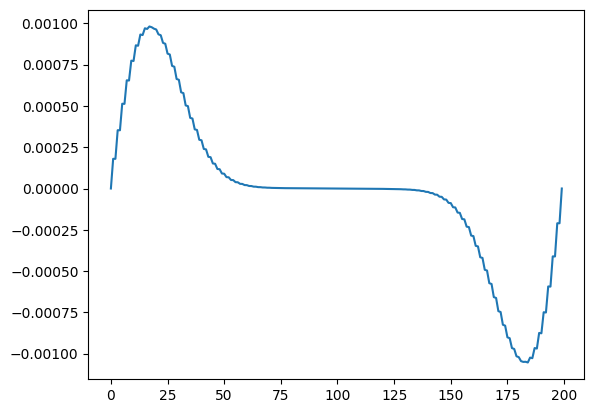

In [32]:
plt.plot(eoinscode['gradient'][:,0])